In [222]:
import pandas as pd
import numpy as np
import math as mt

import tensorflow as tf
from tensorflow.python.framework import ops

from sklearn.metrics import accuracy_score, r2_score, mean_squared_error, mean_absolute_error
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score

from sklearn.ensemble import GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.cluster import KMeans
from sklearn.kernel_ridge import KernelRidge

import xgboost

from sklearn.model_selection import StratifiedKFold, GridSearchCV, train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, OneHotEncoder, LabelBinarizer

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['test']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [223]:
#
# Helpers
#
def write_to_submission_file(predicted_labels, sale_ids, out_file="submission.csv", target='SalePrice', index_label="Id"):
    
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = sale_ids,
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [224]:
# Load House train and test data
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [225]:
# Put the labels aside
labels_orig = train.SalePrice.as_matrix().reshape(-1, 1)

In [226]:
# This will be needed after pre-processing
size_of_train = train.shape[0]
print(size_of_train)

1460


In [227]:
# Merge datasets
del train['SalePrice']

train = pd.concat([train, test])

In [228]:
# Which columns have NaN values?
count = 0

for col in train.columns:
    if(train[col].isnull().sum() > 0):
        print(col)
        count = count + 1
        
print("Total", count, "columns with NaNs")

MSZoning
LotFrontage
Alley
Utilities
Exterior1st
Exterior2nd
MasVnrType
MasVnrArea
BsmtQual
BsmtCond
BsmtExposure
BsmtFinType1
BsmtFinSF1
BsmtFinType2
BsmtFinSF2
BsmtUnfSF
TotalBsmtSF
Electrical
BsmtFullBath
BsmtHalfBath
KitchenQual
Functional
FireplaceQu
GarageType
GarageYrBlt
GarageFinish
GarageCars
GarageArea
GarageQual
GarageCond
PoolQC
Fence
MiscFeature
SaleType
Total 34 columns with NaNs


In [229]:
# Поиграем с NaN еще раз
#train[train.GarageType.isnull()][['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']].sum().sum()
#train[train.FireplaceQu.isnull()][['Fireplaces', 'FireplaceQu']].sum().sum()
#train[train.BsmtExposure.isnull()][['Id', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']] #.sum().sum()
#train[train.MasVnrType.isnull()][['MasVnrType', 'MasVnrArea']] #.sum().sum()
#train[train.Alley.isnull()][['LotFrontage', 'Alley']] #.sum().sum()

In [230]:
# Utilities
train[train.Electrical.isnull()][['Neighborhood', 'Id', 'MSSubClass']]

,Neighborhood,Id,MSSubClass
1379,Timber,1380,80


In [231]:
train[(train.Neighborhood == 'Timber') & (train.MSSubClass == 80)][['Id', 'Electrical', 'MSSubClass', 'YearBuilt', 'MSZoning']]

,Id,Electrical,MSSubClass,YearBuilt,MSZoning
530,531,SBrkr,80,1988,RL
731,732,SBrkr,80,2003,RL
1379,1380,NaN,80,2006,RL
463,1924,SBrkr,80,1987,RL
769,2230,SBrkr,80,2006,RL


In [232]:
# Define variables
cols = []
cols_count = 0

# Делать предсказания по наиболее коррелирующим фичам
use_fe_1 = False
fe_1_cols = []

# Handling years as categorial 
use_fe_2 = True

# Using kind of a total sum of square feet
use_fe_3 = True

# Using new feature of Clustering
use_fe_4 = False

In [233]:
# MSSubClass
enc = OneHotEncoder(sparse=False)
features = enc.fit_transform(train.MSSubClass.values.reshape(-1, 1))
cols_count = cols_count + 1

# MSZoning
#train.MSZoning.fillna("RM", inplace=True)
train.MSZoning.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MSZoning).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotFrontage
train.LotFrontage.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.LotFrontage.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# LotArea
features = np.concatenate( [features, train.LotArea.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# Street
features = np.concatenate( [features, pd.get_dummies(train.Street).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Alley
train.Alley.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Alley).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotShape
features = np.concatenate( [features, pd.get_dummies(train.LotShape).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LandContour
features = np.concatenate( [features, pd.get_dummies(train.LandContour).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [234]:
# Utilities
#train.Utilities.fillna("AllPub", inplace=True)
train.Utilities.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Utilities).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LotConfig
features = np.concatenate( [features, pd.get_dummies(train.LotConfig).as_matrix()], axis=1 )
cols_count = cols_count + 1

# LandSlope
features = np.concatenate( [features, pd.get_dummies(train.LandSlope).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Neighborhood 
features = np.concatenate( [features, pd.get_dummies(train.Neighborhood).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Condition1
features = np.concatenate( [features, pd.get_dummies(train.Condition1).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Condition2
features = np.concatenate( [features, pd.get_dummies(train.Condition2).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BldgType
features = np.concatenate( [features, pd.get_dummies(train.BldgType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# HouseStyle
features = np.concatenate( [features, pd.get_dummies(train.HouseStyle).as_matrix()], axis=1 )
cols_count = cols_count + 1

# OverallQual
enc = OneHotEncoder(sparse=False)
features = np.concatenate( [features, enc.fit_transform(train.OverallQual.values.reshape(-1, 1))], axis=1 )
cols_count = cols_count + 1

# OverallCond
enc = OneHotEncoder(sparse=False)
features = np.concatenate( [features, enc.fit_transform(train.OverallCond.values.reshape(-1, 1))], axis=1 )
cols_count = cols_count + 1

In [235]:
# YearBuilt
if (use_fe_2):
    features = np.concatenate( [features, pd.get_dummies(train.YearBuilt).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YearBuilt.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# YearRemodAdd
if (False):
    features = np.concatenate( [features, pd.get_dummies(train.YearRemodAdd).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YearRemodAdd.as_matrix().reshape(-1, 1)], axis=1 )

cols_count = cols_count + 1

# RoofStyle
features = np.concatenate( [features, pd.get_dummies(train.RoofStyle).as_matrix()], axis=1 )
cols_count = cols_count + 1

# RoofMatl
features = np.concatenate( [features, pd.get_dummies(train.RoofMatl).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Exterior1st
#train.Exterior1st.fillna("Wd Sdng", inplace=True)
train.Exterior1st.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Exterior1st).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Exterior2nd
#train.Exterior2nd.fillna("Wd Sdng", inplace=True)
train.Exterior2nd.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Exterior2nd).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MasVnrType
#train.MasVnrType.fillna("None", inplace=True)
train.MasVnrType.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MasVnrType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MasVnrArea
train.MasVnrArea.fillna(0.0, inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MasVnrArea).as_matrix()], axis=1 )
cols_count = cols_count + 1

# ExterQual
features = np.concatenate( [features, pd.get_dummies(train.ExterQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# ExterCond
features = np.concatenate( [features, pd.get_dummies(train.ExterCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [236]:
# Foundation
features = np.concatenate( [features, pd.get_dummies(train.Foundation).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtQual
train.BsmtQual.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtCond
train.BsmtCond.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtExposure
train.BsmtExposure.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtExposure).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinType1
train.BsmtFinType1.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtFinType1).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinSF1
train.BsmtFinSF1.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFinSF1.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtFinType2
train.BsmtFinType2.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.BsmtFinType2).as_matrix()], axis=1 )
cols_count = cols_count + 1

# BsmtFinSF2
train.BsmtFinSF2.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFinSF2.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtUnfSF
train.BsmtUnfSF.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtUnfSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# TotalBsmtSF
train.TotalBsmtSF.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.TotalBsmtSF.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

In [237]:
# Heating
features = np.concatenate( [features, pd.get_dummies(train.Heating).as_matrix()], axis=1 )
cols_count = cols_count + 1

# HeatingQC
features = np.concatenate( [features, pd.get_dummies(train.HeatingQC).as_matrix()], axis=1 )
cols_count = cols_count + 1

# CentralAir
features = np.concatenate( [features, pd.get_dummies(train.CentralAir).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Electrical
train.Electrical.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Electrical).as_matrix()], axis=1 )
cols_count = cols_count + 1

# 1stFlrSF
features = np.concatenate( [features, train['1stFlrSF'].as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# 2ndFlrSF
features = np.concatenate( [features, train['2ndFlrSF'].as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# LowQualFinSF
features = np.concatenate( [features, train.LowQualFinSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# GrLivArea
features = np.concatenate( [features, train.GrLivArea.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# BsmtFullBath
train.BsmtFullBath.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtFullBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BsmtHalfBath
train.BsmtHalfBath.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.BsmtHalfBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

In [238]:
# FullBath
features = np.concatenate( [features, train.FullBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# HalfBath
features = np.concatenate( [features, train.HalfBath.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# BedroomAbvGr
features = np.concatenate( [features, train.BedroomAbvGr.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# KitchenAbvGr
features = np.concatenate( [features, train.KitchenAbvGr.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# KitchenQual
#train.KitchenQual.fillna("TA", inplace=True)
train.KitchenQual.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.KitchenQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# TotRmsAbvGrd
features = np.concatenate( [features, train.TotRmsAbvGrd.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# Functional
#train.Functional.fillna("Typ", inplace=True)
train.Functional.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Functional).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Fireplaces
features = np.concatenate( [features, train.Fireplaces.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# FireplaceQu
train.FireplaceQu.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.FireplaceQu).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageType
train.GarageType.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageType).as_matrix()], axis=1 )
cols_count = cols_count + 1

In [239]:
# GarageYrBlt
train.GarageYrBlt.fillna(0.0, inplace=True)

if (False):
    features = np.concatenate( [features, pd.get_dummies(train.GarageYrBlt).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.GarageYrBlt.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# GarageFinish
train.GarageFinish.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageFinish).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageCars
train.GarageCars.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.GarageCars.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# GarageArea
train.GarageArea.fillna(0.0, inplace=True)
features = np.concatenate( [features, train.GarageArea.as_matrix().reshape(-1, 1)], axis=1 )

if (use_fe_1):
    fe_1_cols.append(features.shape[1] - 1)
    
cols_count = cols_count + 1

# GarageQual
train.GarageQual.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageQual).as_matrix()], axis=1 )
cols_count = cols_count + 1

# GarageCond
train.GarageCond.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.GarageCond).as_matrix()], axis=1 )
cols_count = cols_count + 1

# PavedDrive
features = np.concatenate( [features, pd.get_dummies(train.PavedDrive).as_matrix()], axis=1 )
cols_count = cols_count + 1

# WoodDeckSF
features = np.concatenate( [features, train.WoodDeckSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# OpenPorchSF
features = np.concatenate( [features, train.OpenPorchSF.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# EnclosedPorch
features = np.concatenate( [features, train.EnclosedPorch.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

In [240]:
# 3SsnPorch
features = np.concatenate( [features, train['3SsnPorch'].as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# ScreenPorch
features = np.concatenate( [features, train.ScreenPorch.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# PoolArea
features = np.concatenate( [features, train.PoolArea.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# PoolQC
train.PoolQC.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.PoolQC).as_matrix()], axis=1 )
cols_count = cols_count + 1

# Fence
train.Fence.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.Fence).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MiscFeature
train.MiscFeature.fillna("NA", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.MiscFeature).as_matrix()], axis=1 )
cols_count = cols_count + 1

# MiscVal
features = np.concatenate( [features, train.MiscVal.as_matrix().reshape(-1, 1)], axis=1 )
cols_count = cols_count + 1

# MoSold
features = np.concatenate( [features, pd.get_dummies(train.MoSold).as_matrix()], axis=1 )
cols_count = cols_count + 1

# YrSold
if (use_fe_2):
    features = np.concatenate( [features, pd.get_dummies(train.YrSold).as_matrix()], axis=1 )
else:
    features = np.concatenate( [features, train.YrSold.as_matrix().reshape(-1, 1)], axis=1 )
    
cols_count = cols_count + 1

# SaleType
#train.SaleType.fillna("WD", inplace=True)
train.SaleType.fillna("Unknown", inplace=True)
features = np.concatenate( [features, pd.get_dummies(train.SaleType).as_matrix()], axis=1 )
cols_count = cols_count + 1

# SaleCondition
features = np.concatenate( [features, pd.get_dummies(train.SaleCondition).as_matrix()], axis=1 )
cols_count = cols_count + 1 

### Feature Engineering 3: using sum of all squares

In [241]:
# LivingAreaSF
if (use_fe_3):
    train['LivingAreaSF'] = train['1stFlrSF'] + train['2ndFlrSF'] + train['TotalBsmtSF'] #+ train['GarageArea']
    
    features = np.concatenate( [features, train.LivingAreaSF.as_matrix().reshape(-1, 1)], axis=1 )
    cols_count = cols_count + 1

In [242]:
print("Total features processed:", cols_count)

Total features processed: 80


In [243]:
# Combine all columns-matrices together
#features = numpy.concatenate(cols, axis=1)

#labels = train.SalePrice.values.reshape(-1, 1)
labels = labels_orig

In [244]:
#
# Scaling
#

# First scale labels
labels = labels.astype(float)
labels_max = labels.max()

labels = labels / labels_max

# Now scale features
count = 0
    
for jj in range(features.shape[1]):
    if((features[:, jj] > 25.).sum() > 0):
        mx = float(features[:, jj].max())

        features[:, jj] = features[:, jj] / mx
        count = count + 1
        
print("Total", count, "features scaled")

Total 21 features scaled


In [245]:
# Split for train and test sets
features_train = features[:size_of_train, :]
labels_train = labels
features_test = features[size_of_train:, :]

In [246]:
if (use_fe_4):
    k_means = KMeans(n_clusters=22, random_state=23, n_jobs=-1)
    k_means.fit(features_train)
    
    prediction = k_means.predict(features_train)
    features_train = np.concatenate((features_train, prediction.reshape(-1, 1)), axis=1)
    
    prediction = k_means.predict(features_test)
    features_test = np.concatenate((features_test, prediction.reshape(-1, 1)), axis=1)
    
    print("Clustering completed.")

In [247]:
print(features_train.shape)
print(labels_train.shape)
print(features_test.shape)

(1460, 919)
(1460, 1)
(1459, 919)


### Baseline

In [145]:
#
# For Averaging
#

results = pd.DataFrame()

In [146]:
clf = GradientBoostingRegressor(n_estimators=300, min_samples_split=5, min_samples_leaf=2, random_state=23)
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

results['GBM'] = prediction.reshape(-1)

In [47]:
# Baseline Submission
write_to_submission_file(prediction * labels_max, test.Id, out_file="submission.GBM.200.FE.csv", target='SalePrice', index_label="Id")
#write_to_submission_file(prediction, test.Id, out_file="submission.GBM.300.csv", target='SalePrice', index_label="Id")

### XGBoost

In [147]:
XGB = xgboost.XGBRegressor(max_depth=3, n_estimators=350)
XGB.fit(features_train, labels_train.reshape(-1))

prediction = XGB.predict(features_test)

results['XGB'] = prediction.reshape(-1)

### Kernel Ridge

In [148]:
clf = KernelRidge(alpha=0.1, gamma=0.0046415888336127772, kernel='rbf')
clf.fit(features_train, labels_train.reshape(-1))
prediction = clf.predict(features_test)

results['K_Ridge'] = prediction.reshape(-1)

### Averaging

In [150]:
#results

In [151]:
average = np.mean(results[['GBM', 'K_Ridge', 'XGB']], axis=1)
prediction = average.as_matrix()

In [152]:
# Baseline Submission
write_to_submission_file(prediction * labels_max, test.Id, out_file="submission.Average.csv", target='SalePrice', index_label="Id")

### Neural Network

In [108]:
# Transpose to have the shape of (num_of_features, num_of_examples)
features_train = features_train.T
labels_train = labels_train.T
features_test = features_test.T
#labels_test = labels_test.T

In [109]:
# Helper functions
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of a input data vector 
    n_y -- scalar, size of output data
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(n_x, None), name = "X")
    Y = tf.placeholder(tf.float32, shape=(n_y, None), name = "Y")
    LR = tf.placeholder(tf.float32, name = "LR")
    
    return X, Y, LR

In [116]:
# Helper functions
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [96, 801]
                        b1 : [96, 1]
                        W2 : [64, 96]
                        b2 : [64, 1]
                        W3 : [32, 64]
                        b3 : [32, 1]
                        W4 : [8, 32]
                        b4 : [8, 1]
                        W5 : [1, 8]
                        b5 : [1, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3, W4, b4, W5, b5
    """
    
    tf.set_random_seed(23)                   
        
    W1 = tf.get_variable("W1", [96, 801], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b1 = tf.get_variable("b1", [96, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [96, 96], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b2 = tf.get_variable("b2", [96, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [32, 96], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b3 = tf.get_variable("b3", [32, 1], initializer = tf.zeros_initializer())
    W4 = tf.get_variable("W4", [16, 32], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b4 = tf.get_variable("b4", [16, 1], initializer = tf.zeros_initializer())
    W5 = tf.get_variable("W5", [1, 16], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
    b5 = tf.get_variable("b5", [1, 1], initializer = tf.zeros_initializer())

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3,
                  "W4": W4,
                  "b4": b4,
                  "W5": W5,
                  "b5": b5}
    
    return parameters

In [117]:
# Helper functions
def forward_propagation(X, parameters, keep_prob):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    W4 = parameters['W4']
    b4 = parameters['b4']
    W5 = parameters['W5']
    b5 = parameters['b5']
    
    # The model
    Z1 = tf.add(tf.matmul(W1, X), b1)                                              
    A1 = tf.nn.dropout(tf.nn.relu(Z1), keep_prob)
    #A1 = tf.nn.relu(Z1)
    
    Z2 = tf.add(tf.matmul(W2, A1), b2)                                              
    A2 = tf.nn.dropout(tf.nn.relu(Z2), keep_prob)
    #A2 = tf.nn.relu(Z2)
    
    Z3 = tf.add(tf.matmul(W3, A2), b3)
    A3 = tf.nn.dropout(tf.nn.relu(Z3), keep_prob)
    #A3 = tf.nn.relu(Z3)
    
    Z4 = tf.add(tf.matmul(W4, A3), b4)    
    A4 = tf.nn.dropout(tf.nn.relu(Z4), keep_prob)
    #A4 = tf.nn.relu(Z4)
    
    Z5 = tf.add(tf.matmul(W5, A4), b5)    
    
    return Z5

In [118]:
# Helper functions
def compute_cost(Yhat, Y, parameters, lambd=0.0):
    """
    Computes the cost
    
    Arguments:
    Yhat -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    W3 = parameters['W3']
    W4 = parameters['W4']
    W5 = parameters['W5']
    
    cost = tf.reduce_mean(
        tf.nn.l2_loss(Yhat - Y) +
        lambd*tf.nn.l2_loss(W1) + lambd*tf.nn.l2_loss(W2) + 
        lambd*tf.nn.l2_loss(W3) + lambd*tf.nn.l2_loss(W4) +
        lambd*tf.nn.l2_loss(W5))
    
    return cost

In [134]:
# Helper functions
def model(X_train, Y_train, X_test, learning_rate=0.001, lambd=0.0, keep_prob=1.0,
          num_epochs=1000, minibatch_size=64, print_cost=True):
    """
    Implements a multi-layer tensorflow neural network
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    lambd -- regularization parameter
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # To follow MAE on train set
    train_mae = []
    
    # Create Placeholders of shape (n_x, n_y)
    X, Y, LR = create_placeholders(n_x, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    last_activation = forward_propagation(X, parameters, keep_prob)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(last_activation, Y, parameters, lambd)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=LR).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for iteration in range(num_epochs):
            
            # Floating learning rate
            if ((iteration > 0) and (iteration % 5000 == 0)):
                learning_rate = learning_rate / 1.75

            # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
            yhat, _ , iteration_cost = sess.run([last_activation, optimizer, cost], feed_dict={X: X_train, Y: Y_train, LR: learning_rate})
                
            # Print the cost 
            #print(iteration_cost)
            
            if (iteration % 1000 == 0):
                print ("Cost at iteration %i: %f" % (iteration, iteration_cost))
            if (iteration % 25 == 0):
                costs.append(iteration_cost)
                
                # Compute MAE on train set
                mae = mean_absolute_error(yhat.T, yhat.T)
                train_mae.append(mae)
                
        # Results Visualization
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

        # plot the cost
        plt.subplot(1, 2, 1)
        plt.plot(costs, 'b-')
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))

        # plot MAE on train set
        plt.subplot(1, 2, 2)
        plt.plot(train_mae, 'r-')
        plt.ylabel('Mean Absolute Error')
        plt.xlabel('Iterations')
        plt.title("Mean Absolute Error on Train Data")

        plt.show()  

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        print("Final loss on train data:", iteration_cost)
        print("Minimum MAE on train data:", np.min(train_mae))
        print("Final MAE on train data:", train_mae[-1])
        
        # Make prediction
        yhat = sess.run(last_activation, feed_dict={X: X_test})
        
        return parameters, yhat

Cost at iteration 0: 23.904346
Cost at iteration 1000: 1.149172
Cost at iteration 2000: 0.646066
Cost at iteration 3000: 0.502343
Cost at iteration 4000: 0.349999
Cost at iteration 5000: 0.360314
Cost at iteration 6000: 0.250452
Cost at iteration 7000: 0.280976
Cost at iteration 8000: 0.266132
Cost at iteration 9000: 0.191114
Cost at iteration 10000: 0.199377
Cost at iteration 11000: 0.168941
Cost at iteration 12000: 0.181368
Cost at iteration 13000: 0.195947
Cost at iteration 14000: 0.192466
Cost at iteration 15000: 0.177084
Cost at iteration 16000: 0.185412
Cost at iteration 17000: 0.187225
Cost at iteration 18000: 0.187850
Cost at iteration 19000: 0.200688
Cost at iteration 20000: 0.217009
Cost at iteration 21000: 0.227951
Cost at iteration 22000: 0.173545
Cost at iteration 23000: 0.148858
Cost at iteration 24000: 0.180266
Cost at iteration 25000: 0.165702
Cost at iteration 26000: 0.187896
Cost at iteration 27000: 0.187457
Cost at iteration 28000: 0.163753
Cost at iteration 29000: 0

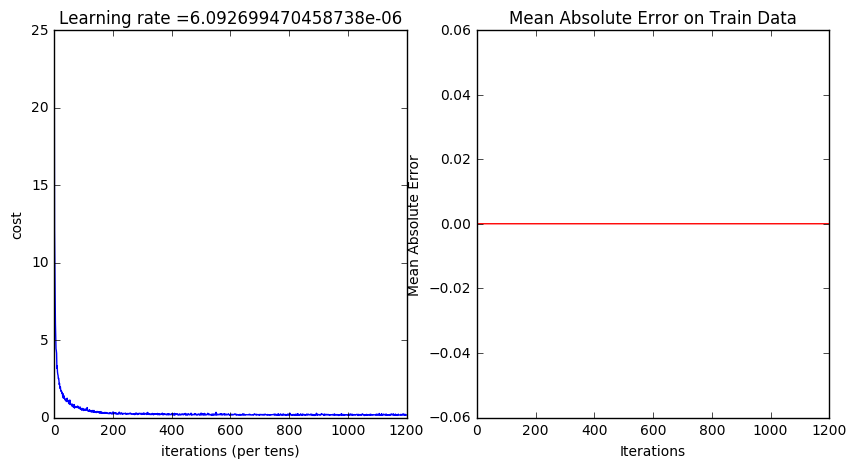

Parameters have been trained!
Final loss on train data: 0.165383
Minimum MAE on train data: 0.0
Final MAE on train data: 0.0
Wall time: 24min 26s


In [135]:
%%time
parameters, prediction = model(features_train, labels_train, features_test, learning_rate=0.0001, keep_prob=0.9, num_epochs=30000)

In [137]:
# NN Submission
write_to_submission_file((prediction * labels_max).reshape(-1, 1), test.Id, out_file="submission.NN.csv", target='SalePrice', index_label="Id")

Cost at iteration 0: 32.413219
Cost at iteration 1000: 1.271925
Cost at iteration 2000: 0.918187
Cost at iteration 3000: 0.618559
Cost at iteration 4000: 0.384909
Cost at iteration 5000: 0.263130
Cost at iteration 6000: 0.194797
Cost at iteration 7000: 0.151880
Cost at iteration 8000: 0.126784
Cost at iteration 9000: 0.111113
Cost at iteration 10000: 0.095203
Cost at iteration 11000: 0.084178
Cost at iteration 12000: 0.075312
Cost at iteration 13000: 0.069634
Cost at iteration 14000: 0.069298
Cost at iteration 15000: 0.063412
Cost at iteration 16000: 0.058840
Cost at iteration 17000: 0.054235
Cost at iteration 18000: 0.052187
Cost at iteration 19000: 0.050417
Cost at iteration 20000: 0.050401
Cost at iteration 21000: 0.048579
Cost at iteration 22000: 0.046250
Cost at iteration 23000: 0.040704
Cost at iteration 24000: 0.045036
Cost at iteration 25000: 0.040324
Cost at iteration 26000: 0.038898
Cost at iteration 27000: 0.035791
Cost at iteration 28000: 0.036549
Cost at iteration 29000: 0

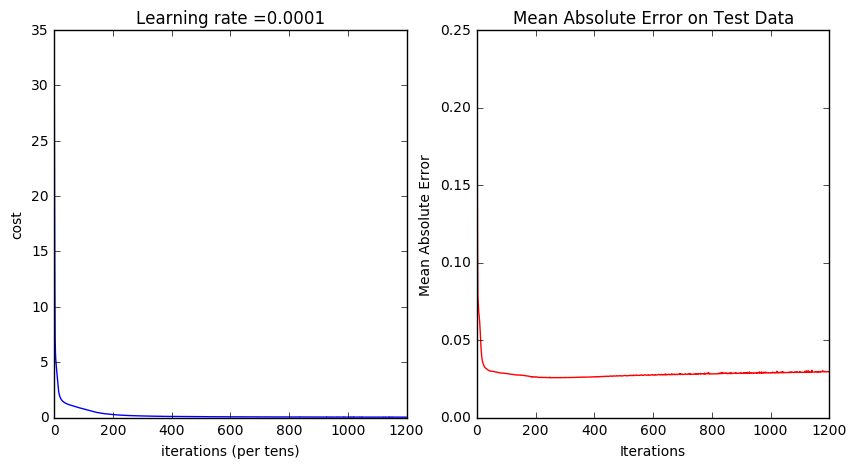

Parameters have been trained!
Final loss on train data: 0.0374182
Minimum MAE on test data: 0.0256705021057
Final MAE on test data: 0.0295855028918
Loss on test data: 0.45955
Wall time: 16min 36s


In [1411]:
%%time
#parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, keep_prob=0.8, num_epochs=30000)
parameters, prediction = model(features_train, labels_train, features_test, labels_test, learning_rate=0.0001, lambd=0.00001, num_epochs=30000)

In [130]:
prediction.shape

(1, 1460)

In [1242]:
(prediction * labels_max).reshape(-1)[:20]

array([ 163840.75     ,  170094.546875 ,  163416.640625 ,  111271.9609375,
        151992.046875 ,  218355.8125   ,   99572.6875   ,  386877.8125   ,
        152057.734375 ,  364481.5625   ,  162330.046875 ,  283493.375    ,
        295168.5625   ,  149298.546875 ,  111930.546875 ,  137187.53125  ,
        139007.5      ,  154961.375    ,   92957.28125  ,   93675.3203125], dtype=float32)

In [1243]:
(labels_test * labels_max).reshape(-1)[:20]

array([ 186000.,  214500.,  177000.,  185000.,   60000.,  223500.,
         64500.,  437154.,  135000.,  440000.,  182900.,  207500.,
        257500.,  164500.,  121000.,   34900.,  145000.,  175000.,
         79900.,  118500.])

In [1260]:
print(mean_absolute_error(labels_test, prediction))

0.0274287305966
